# Lab1 - Self-Supervised Learning (SSL)

In this course, we will focus on the main steps of implementing [SimCLR](https://proceedings.mlr.press/v119/chen20j) in PyTorch.

1. Image Preprocessing and Augmentation
2. NT-Xent Loss
3. Leave-one-out KNN

## 1. Image Preprocessing and Augmentation

In [1]:
from torchvision import transforms
from IPython.display import display
from PIL import Image

---

### `torchvision`
- Natively supports various image preprocessing functions.
- See [document](https://pytorch.org/vision/stable/transforms.html#scriptable-transforms) for all available preprocessing functions.
- The used transformations in this example:
    - [transforms.RandomHorizontalFlip](https://pytorch.org/vision/stable/generated/torchvision.transforms.RandomHorizontalFlip.html#torchvision.transforms.RandomHorizontalFlip).
    - [transforms.Pad](https://pytorch.org/vision/stable/generated/torchvision.transforms.Pad.html#torchvision.transforms.Pad).

Original:


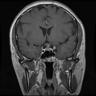

RandomHorizontalFlip(p=0.9):


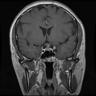

Pad(padding=(0, 0, 8, 16)):


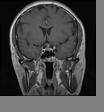

In [2]:
image = Image.open('./0000.jpg')
print("Original:")
display(image)
resize = transforms.RandomHorizontalFlip(p=0.5)
print("RandomHorizontalFlip(p=0.9):")
display(resize(image))
random_resize_crop = transforms.Pad(padding=(0, 0, 8, 16), fill=128)
print("Pad(padding=(0, 0, 8, 16)):")
display(random_resize_crop(image))

---

### Transforms can be composed sequentially to form a stronger augmentation.
- See [transforms.Compose](https://pytorch.org/vision/stable/generated/torchvision.transforms.Compose.html#torchvision.transforms.Compose).

Original:


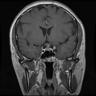

RandomHorizontalFlip(p=0.9) + Pad(padding=(0, 0, 8, 16), fill=128):


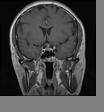

In [3]:
image = Image.open('./0000.jpg')
print("Original:")
display(image)
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.Pad(padding=(0, 0, 8, 16), fill=128),
])
print("RandomHorizontalFlip(p=0.9) + Pad(padding=(0, 0, 8, 16), fill=128):")
display(transform(image))

---

### Checkpoint 1.
Create a `transform` which applies `transforms.RandomHorizontalFlip(p=0.5)` and `transforms.Pad(padding=(0, 0, 8, 16), fill=128)` in a random order.
- Hint: [transforms.RandomOrder](https://pytorch.org/vision/stable/generated/torchvision.transforms.RandomOrder.html#torchvision.transforms.RandomOrder).
- Execute several times to get the results of padding on the left and below.

Original:


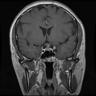

RandomOrder:


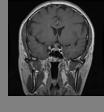

In [4]:
image = Image.open('./0000.jpg')
print("Original:")
display(image)
transform = transforms.RandomOrder([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.Pad(padding=(0, 0, 8, 16), fill=128),
])
print("RandomOrder:")
display(transform(image))

---

## 2. The (N)ormalized (T)emperature-scaled (C)ross (Ent)ropy Loss (NT-Xent)

### Notation Definition

- Let $u$ and $v$ be the encoded features of an image in different views (different augmentation).

- The similarity of $u$ and $v$ is defined as $\text{sim}(u,v)=\frac{u^Tv}{\vert u\vert\vert v\vert}$.

- For a batch of $N$ images, there are $2N$ encoded features:

    $$
    \{z_i\}_{i=1}^{2N}=\{u_1,u_2,\cdots,u_N,v_1,v_2,\cdots,v_N\}
    $$

### Designs a loss function to learn that the feature $u_i$ can figure out $v_i$ from $(2N-1)$ features.

Let $z_i$ be the reference feature. We can use cross entropy loss (negative log softmax) to make $z_i$ and $z_j$ closer and make $z_i$ father away from $z_k,\forall k\neq j$ at the same time.

$$
\mathcal{L}_{i,j}=-\log\Bigg(\frac{\exp\big(\frac{\text{sim}(z_i,z_j)}{\tau}\big)}{\sum_{k=1}^{2N}\mathbb{1}_{[k\neq i]}\exp\big(\frac{\text{sim}(z_i,z_k)}{\tau}\big)}\Bigg)
$$

where $\tau \le 1$ is a constant to scale up the output range of $\text{sim}(\cdot,\cdot)$ from $[-1, 1]$ to $[\frac{-1}{\tau},\frac{1}{\tau}]$.

Consider all ordered pairs $(u_i, v_i)$ and $(v_i, u_i)$, $\forall i \in \{1,\cdots,N\}$

$$
\mathcal{L}_{\text{NT-Xent}}=\frac{1}{2N}\sum_{i=1}^N \mathcal{L}_{i,i+N} + \mathcal{L}_{i+N,i}
$$

### Implementation
In following, we provide an implementation of batchify NT-Xent loss which does not contain any **for loop** at python level.

In [5]:
import torch
from torch import nn
import torch.nn.functional as F


def nt_xent(
    u: torch.Tensor,  # [N, C]
    v: torch.Tensor,  # [N, C]
    temperature: float = 0.5,
):
    """
    N: batch size
    C: feature dimension
    """
    N, C = u.shape

    z = torch.cat([u, v], dim=0)  # [2N, C]
    z = F.normalize(z, p=2, dim=1)  # [2N, C]
    s = torch.matmul(z, z.t()) / temperature  # [2N, 2N] similarity matrix
    mask = torch.eye(2 * N).bool().to(z.device)  # [2N, 2N] identity matrix
    s = torch.masked_fill(
        s, mask, -float('inf'))  # fill the diagonal with negative infinity
    label = torch.cat([  # [2N]
        torch.arange(N, 2 * N),  # {N, ..., 2N - 1}
        torch.arange(N),  # {0, ..., N - 1}
    ]).to(z.device)

    loss = F.cross_entropy(s, label)  # NT-Xent loss
    return loss

### Test `nt_xent`
Load two images ($N=2$) to form a batch data, and define a stochastic transform to get different views.

In [6]:
image0 = Image.open('./0000.jpg')
image1 = Image.open('./0001.jpg')

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomResizedCrop((32, 32), scale=(0.6, 1.0))
])

x1 = torch.stack([
    transform(image0),
    transform(image1),
])  # type: ignore

x2 = torch.stack([
    transform(image0),
    transform(image1),
])  # type: ignore

Define a single layer CNN as the image encoder.

In [7]:
model = nn.Sequential(
    nn.Conv2d(3, 1, kernel_size=5),
    nn.AvgPool2d(1),
    nn.Flatten(start_dim=1),
)

## Checkpoint 2.

Get the encoded features of `x1` and `x2` then calculate the SimCLR loss by function `nt_xent`.

In [8]:
u = model(x1)
v = model(x2)
loss = nt_xent(u, v)
print(loss)

tensor(0.5707, grad_fn=<NllLossBackward0>)


---

## 3. Leave-one-out Cross Validation with K-Nearest Neighbors (KNN)
- Leave-one-out Cross Validation
    
    For each data, the other data are training data.

- KNN
    
    An object is classified by a plurality vote of its $K$ neighbors in training data.

### Implementation
For KNN, the space complexity is $O(N^2\times C)$ where $N$ is the number of data and $C$ is the dimension of feature size. We provide a batchify implementation to reduce memory footprint.

In [9]:
def KNN(emb, cls, batch_size, Ks=[1, 10, 50, 100]):
    """Apply KNN for different K and return the maximum acc"""
    preds = []
    mask = torch.eye(batch_size).bool().to(emb.device)
    mask = F.pad(mask, (0, len(emb) - batch_size))
    for batch_x in torch.split(emb, batch_size):
        dist = torch.norm(
            batch_x.unsqueeze(1) - emb.unsqueeze(0), dim=2, p="fro")
        now_batch_size = len(batch_x)
        mask = mask[:now_batch_size]
        dist = torch.masked_fill(dist, mask, float('inf'))
        # update mask
        mask = F.pad(mask[:, :-now_batch_size], (now_batch_size, 0))
        pred = []
        for K in Ks:
            knn = dist.topk(K, dim=1, largest=False).indices
            knn = cls[knn].cpu()
            pred.append(torch.mode(knn).values)
        pred = torch.stack(pred, dim=0)
        preds.append(pred)
    preds = torch.cat(preds, dim=1)
    accs = [(pred == cls.cpu()).float().mean().item() for pred in preds]
    return max(accs)

### Test this function by two $2$-dimensional Gaussians.

$
\begin{aligned}
x_1&\sim\mathcal{N}\big([0, 0], \mathbf{I_{2\times 2}}\big) \\
x_2&\sim\mathcal{N}\big([3, 3], \mathbf{I_{2\times 2}}\big)
\end{aligned}$

In [10]:
N = 500

embedding = torch.cat([
    torch.randn((N, 2)),       # mean = (0, 0), std = 1
    torch.randn((N, 2)) + 3,   # mean = (3, 3), std = 1
], dim=0)
classes = torch.cat([
    torch.zeros(N),
    torch.ones(N),
], dim=0)
acc = KNN(embedding, classes, batch_size=16)
print("Accuracy: %.5f" % acc)

Accuracy: 0.98300
